In [3]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from PIL import Image
from astropy.table import Table


In [2]:
checkpoint = "/mnt/data/CVPR2025/task1_data/Qwen2-VL-2B-Instruct"
# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    checkpoint, torch_dtype=torch.bfloat16
)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
data = Table.read("/mnt/data/CVPR2025/task1_data/classifications/test_no_classification_addfeat_task3.hdf5")

In [7]:
data['image'][0].shape

(3, 144, 144)

(144, 144, 3)


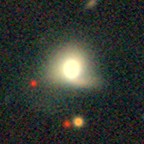

In [27]:
import numpy as np
img_array_transposed = np.transpose(data['image'][4], (1, 2, 0))  # 变成(144,144,3)
# 如果数据是0-1范围的浮点数，需要先转换到0-255范围
if img_array_transposed.max() <= 1.0:
    img_array_transposed = (img_array_transposed * 255).astype(np.uint8)
# 如果已经是0-255范围，直接转换类型
else:
    img_array_transposed = img_array_transposed.astype(np.uint8)
print(img_array_transposed.shape)
img = Image.fromarray(img_array_transposed)
img

In [8]:
min_pixels = 110*110*3
max_pixels = 144*144*3
processor = AutoProcessor.from_pretrained(checkpoint, min_pixels=min_pixels, max_pixels=max_pixels)

In [9]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": data["image"][0]
            },
            {"type": "text", "text": "Redshift is a measure of how much the wavelength of light from a galaxy has been stretched due to the expansion of the universe. It provides crucial information on the galaxy's velocity and distance and can be analyzed through multiple perspectives. Specifically, the <|image_pad|> utilizes celestial image data to obtain observational information such as morphology and luminosity, providing an initial estimate of distance.By integrating the information from these tokens, tell me the redshift value of the celestial object."},
        ],
    }
]

In [10]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [11]:
text = text.replace("<|vision_start|><|image_pad|><|vision_end|>", "").replace(" <|image_pad|> ", "<|vision_start|><|image_pad|><|vision_end|>") #移动image_pad到对应的位置

In [12]:
text

"<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nRedshift is a measure of how much the wavelength of light from a galaxy has been stretched due to the expansion of the universe. It provides crucial information on the galaxy's velocity and distance and can be analyzed through multiple perspectives. Specifically, the<|vision_start|><|image_pad|><|vision_end|>utilizes celestial image data to obtain observational information such as morphology and luminosity, providing an initial estimate of distance.By integrating the information from these tokens, tell me the redshift value of the celestial object.<|im_end|>\n<|im_start|>assistant\n"

In [13]:
image_inputs, video_inputs = process_vision_info(messages)

AttributeError: 'numpy.ndarray' object has no attribute 'startswith'